# Imports

In [169]:
import os
from typing import List

import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from pycirclize import Circos

# Reading File Info

In [3]:
csv_path = "../data/MedFMC_train/chest/chest_train.csv"
image_path = "../data/MedFMC_train/chest/images"

In [4]:
labels = pd.read_csv(csv_path, index_col=0)

In [5]:
labels

,img_id,pleural_effusion,nodule,pneumonia,cardiomegaly,hilar_enlargement,fracture_old,fibrosis,aortic_calcification,tortuous_aorta,thickened_pleura,TB,pneumothorax,emphysema,atelectasis,calcification,pulmonary_edema,increased_lung_markings,elevated_diaphragm,consolidation
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
1,5B91F7409CCCE2.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,5DC2824164E8B52.png,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5E0E86BB348CB90.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5E0D44C4555411F.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5C189D471208E37.png,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,CR.1.2.156.600734.516764694.533640.1571540926....,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4833,DX.1.2.392.200046.100.2.1.69131194618.19110314...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4843,DX.1.2.002926110003388584201910170849368319028...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
image_files = [f for f in os.listdir(image_path) if f.endswith('.png')]

# Data Analysis

## Basic Visualization with Label

In [62]:
def filter_true_labels(all_labels: List[str], labels_one_hot: List[bool]) -> List[str]:
    """Helper function to filter out the true labels from the list of all labels.
        all_labels (List[str]): list of all labels
        true_labels (List[bool]): list of boolean values for each label    
    """ 
    
    assert len(all_labels) == len(labels_one_hot) 
    return [label for label, true in zip(all_labels, labels_one_hot) if true]

In [74]:
def vis_data(num_images: int, image_dir: os.PathLike, df: pd.DataFrame):
    """Visualizes num_images amount of data with their corresponding label."""
    all_labels = df.columns[1:]
    
    image_filenames = df['img_id'].tolist()
    selected_images = random.sample(image_filenames, num_images)
    
    fig, axes = plt.subplots(1, num_images, figsize=(35, 35))
    
    # iterate through df row by row, get the image file and the labels as a list
    # if no label is present, set the text to 'No Finding'
    for i, (row_id, row) in enumerate(df[df['img_id'].isin(selected_images)].iterrows()):
        row = row.tolist()
        img_id = row[0]
        one_hot = row[1:]        
        
        present_labels = filter_true_labels(all_labels, one_hot)
        if len(present_labels) > 0:
            title = " , ".join(present_labels)
        else:
            title = "No Finding"
        
        with Image.open(os.path.join(image_dir, img_id)) as img:
            axes[i].imshow(img)
            axes[i].set_title(title)
            axes[i].axis('off')
            
    plt.show()

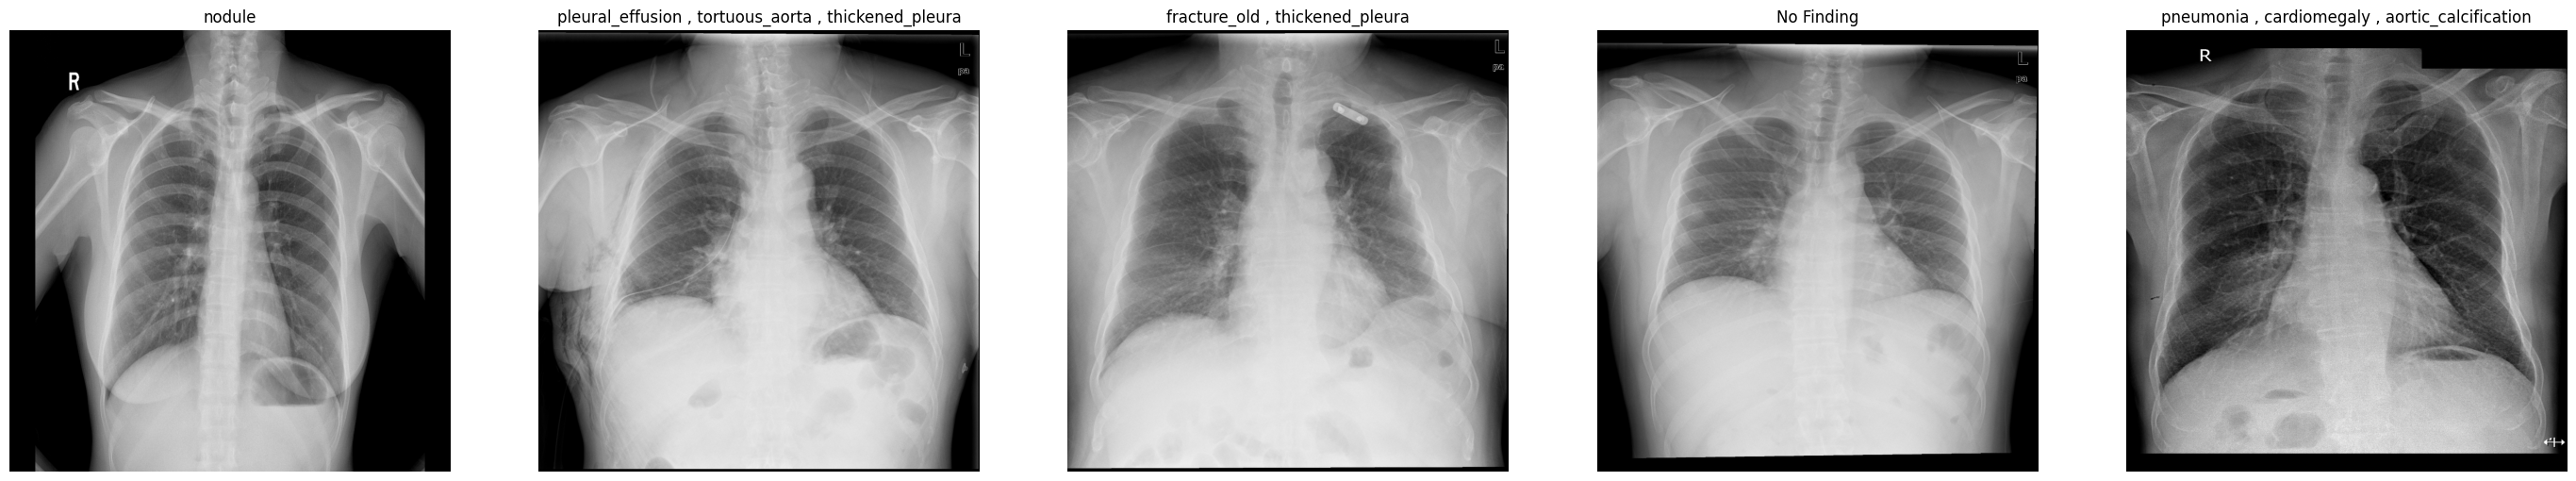

In [77]:
vis_data(5, image_path, labels)

## Label Distribution

In [108]:
def plot_label_distribution(df: pd.DataFrame):
    """Plots the label distribution of the dataset."""
    all_labels = df.columns[1:]
    label_counts = df[all_labels].sum(axis=0).sort_values(ascending=False)

    plt.figure(figsize=(20, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.bar(label_counts.index, label_counts.values)
    plt.xticks(rotation=90)
    
    plt.show()

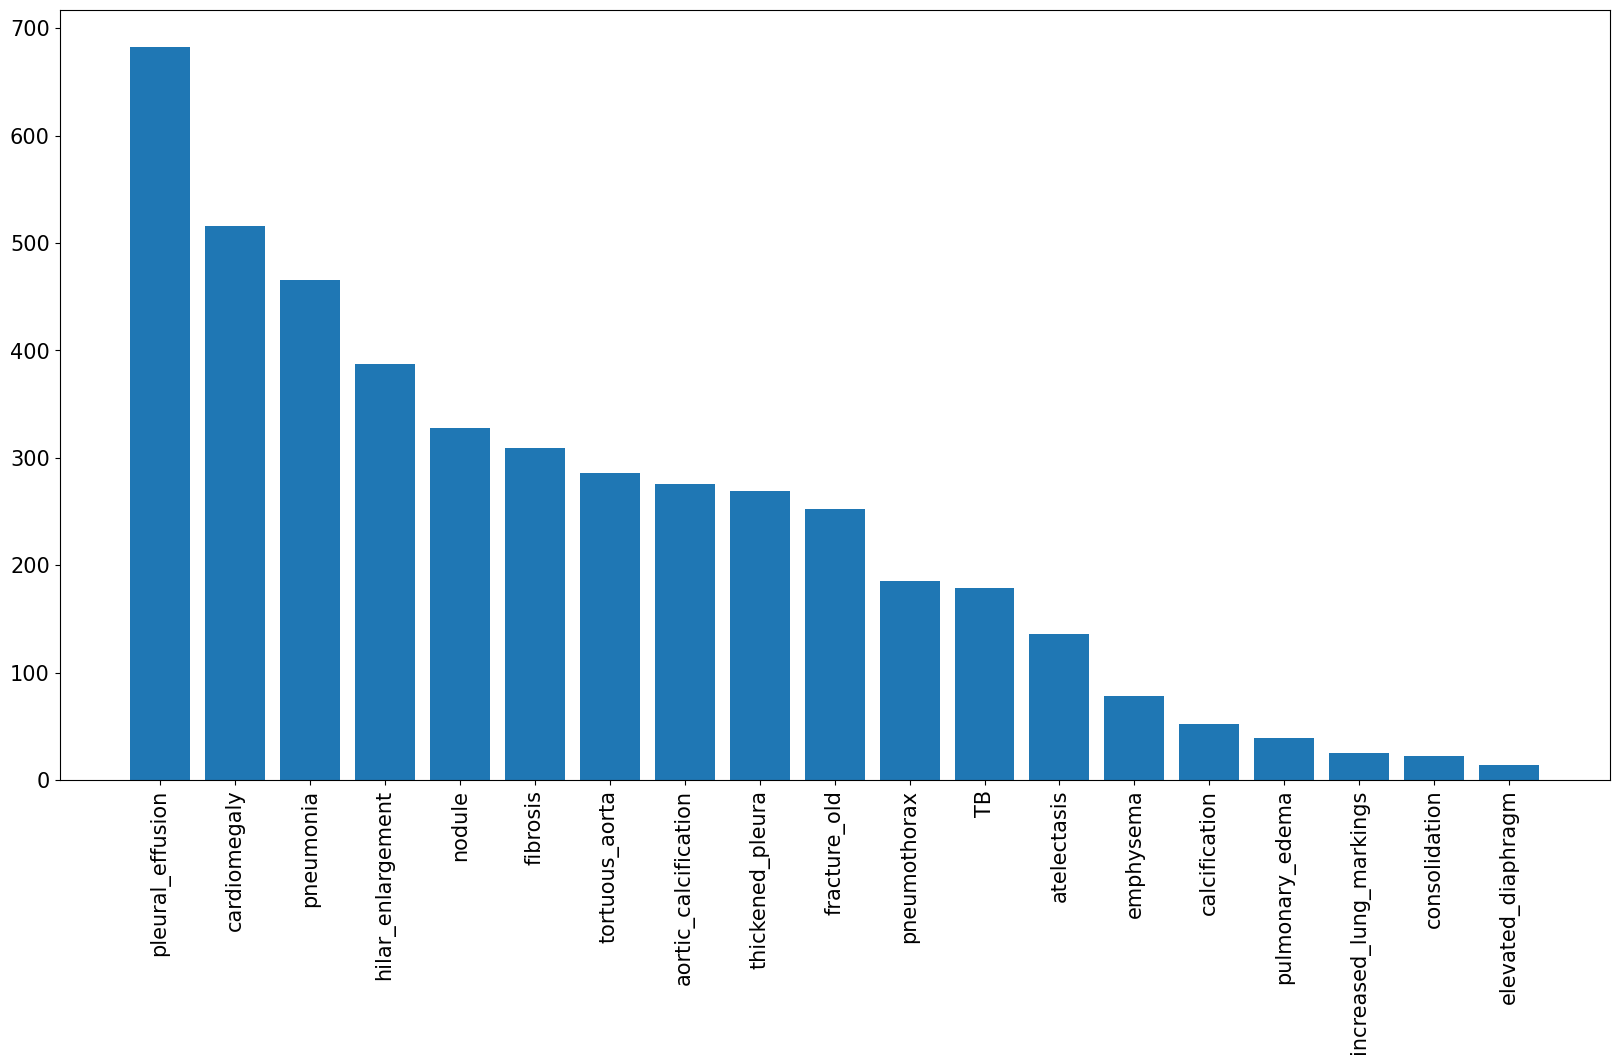

In [109]:
plot_label_distribution(labels)

In [110]:
# plot heatmap of cooccurence matrix
def plot_cooccurence_matrix(df: pd.DataFrame):
    """Plots the cooccurence matrix of the labels as a heatmap."""
    all_labels = df.columns[1:]
    cooccurence_matrix = df[all_labels].T.dot(df[all_labels])
    
    plt.figure(figsize=(20, 20))
    plt.tick_params(axis='both', which='major', labelsize=15)
    
    plt.imshow(cooccurence_matrix)
    plt.xticks(range(len(all_labels)), all_labels, rotation=90)
    plt.yticks(range(len(all_labels)), all_labels)
    plt.colorbar()
    
    plt.show()

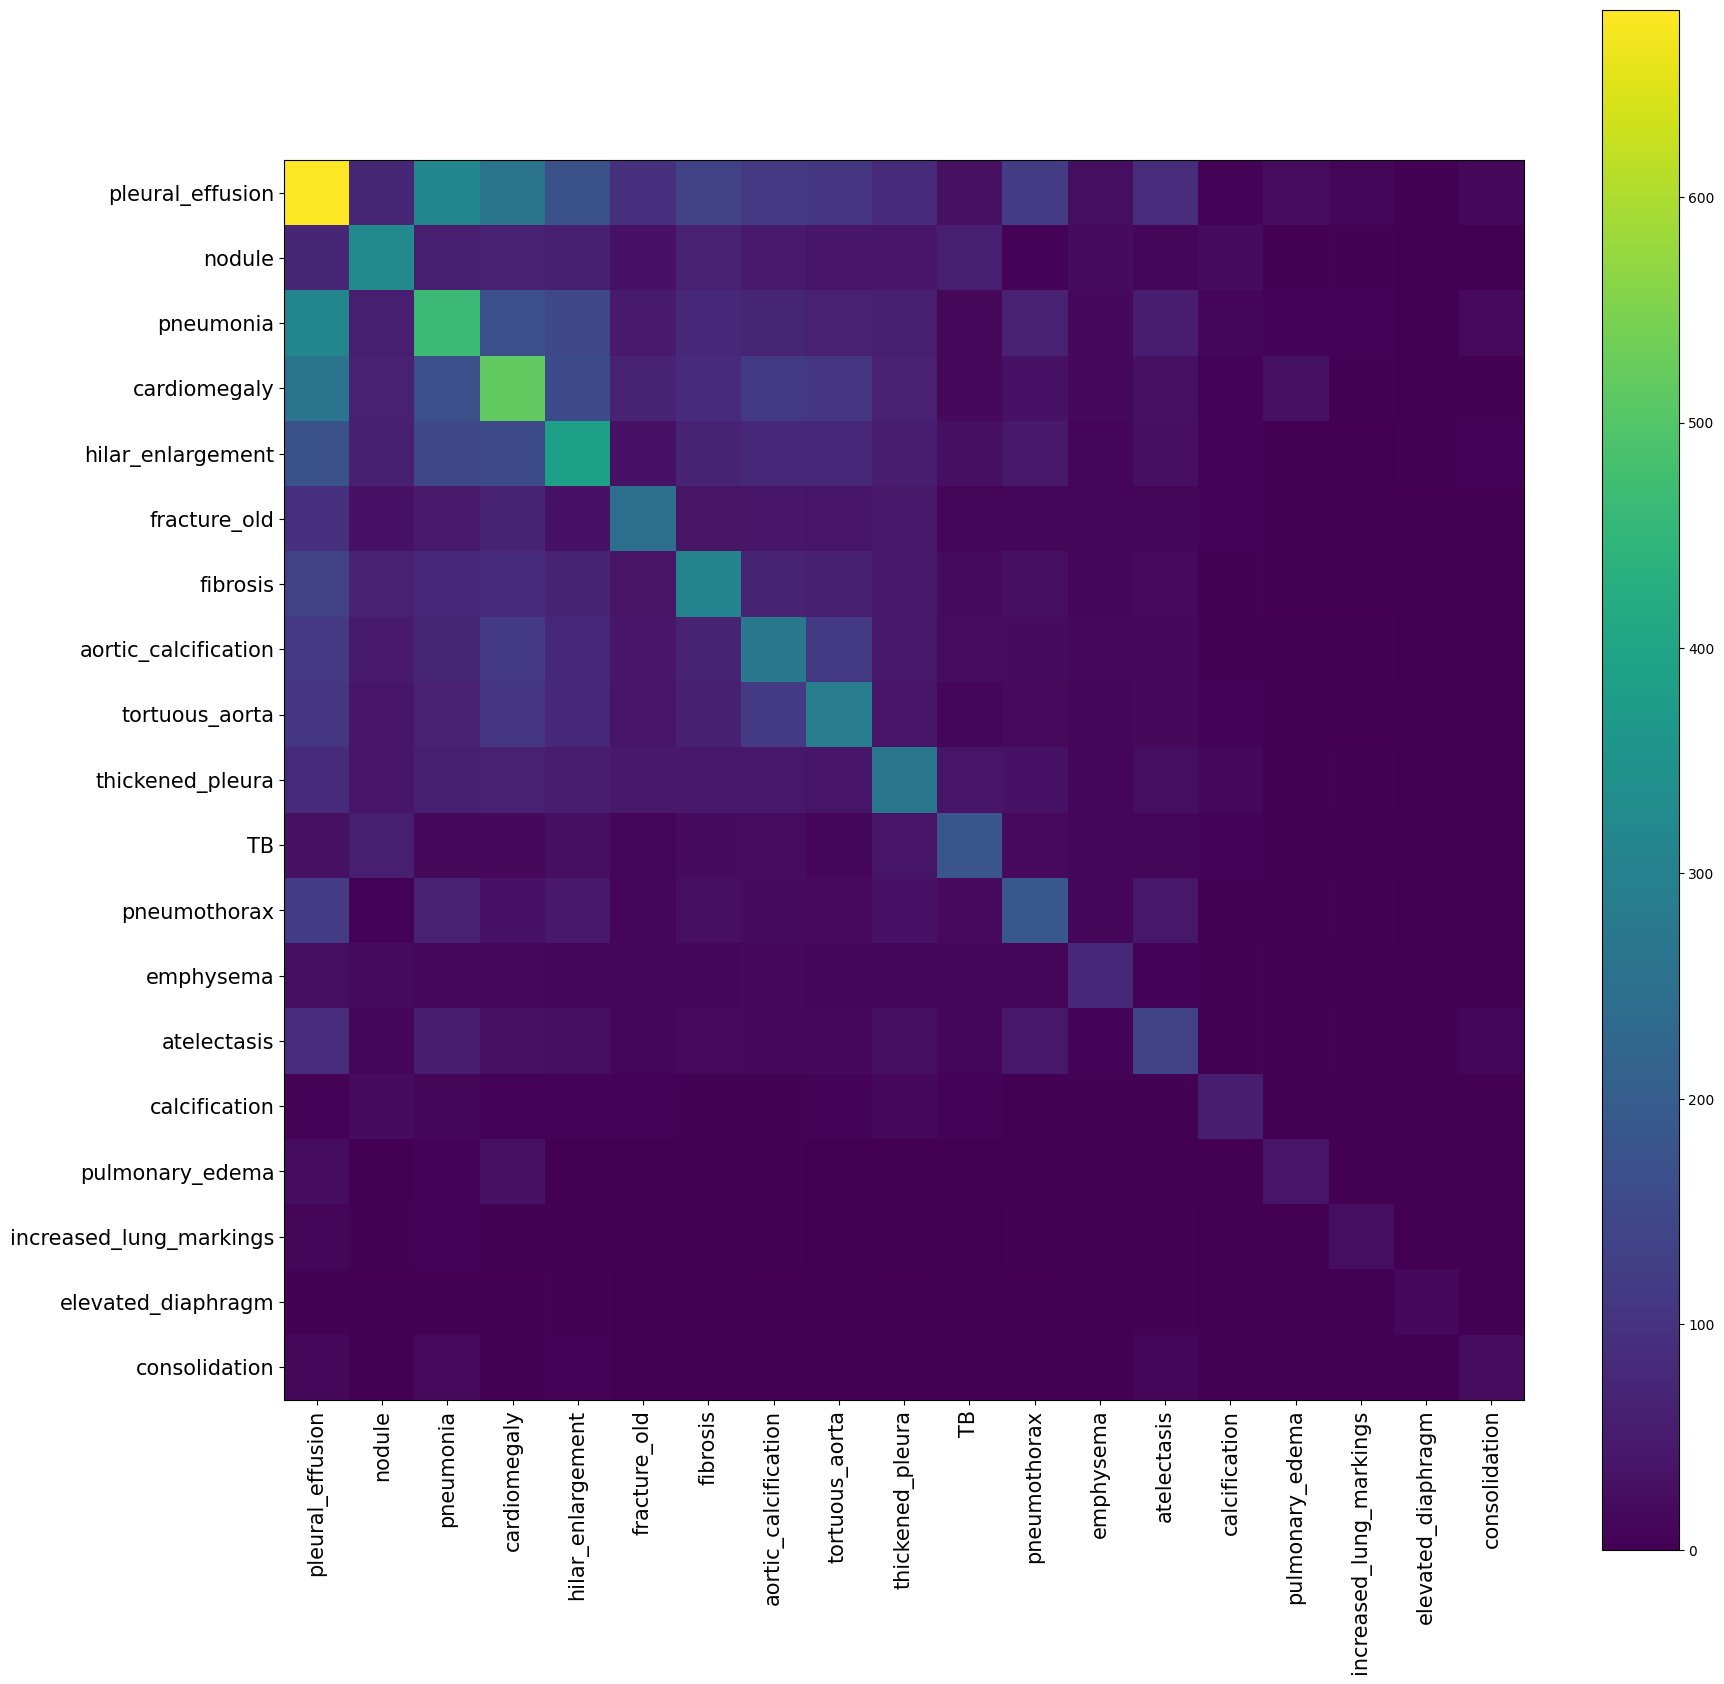

In [111]:
plot_cooccurence_matrix(labels)

In [112]:
# plot heatmap of cooccurence matrix normalized 
def plot_cooccurence_matrix_normalized(df: pd.DataFrame):
    """Plots the cooccurence matrix of the labels as a heatmap normalized."""
    all_labels = df.columns[1:]
    cooccurence_matrix = df[all_labels].T.dot(df[all_labels])
    cooccurence_matrix = cooccurence_matrix / cooccurence_matrix.max()
    
    plt.figure(figsize=(20, 20))
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.imshow(cooccurence_matrix)
    plt.xticks(range(len(all_labels)), all_labels, rotation=90)
    plt.yticks(range(len(all_labels)), all_labels)
    plt.colorbar()

    plt.show()

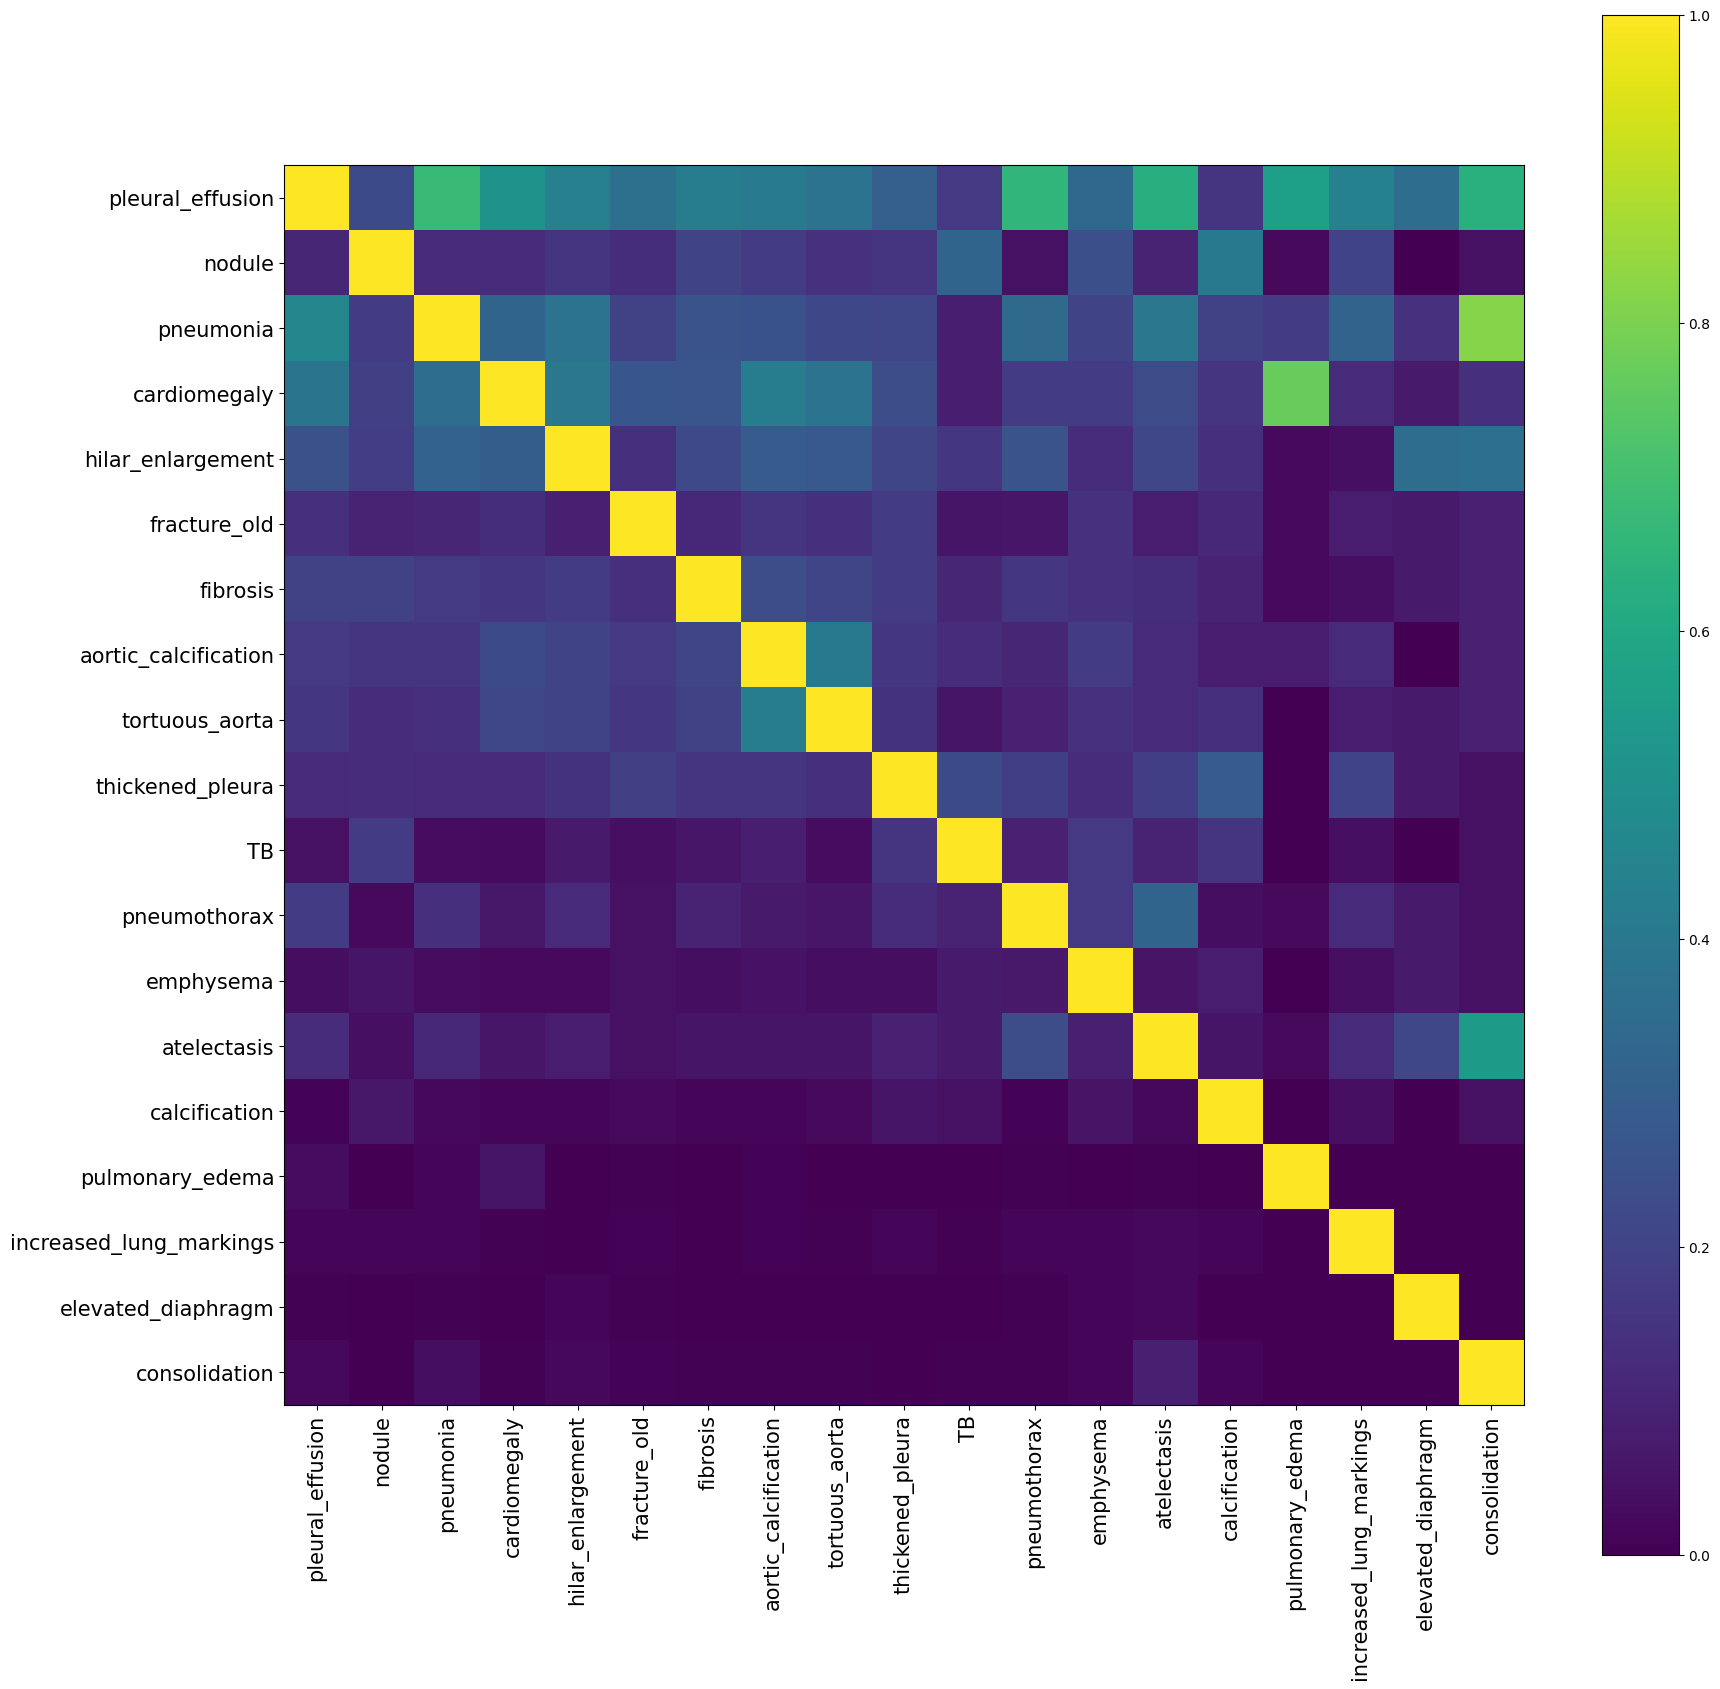

In [113]:
plot_cooccurence_matrix_normalized(labels)

In [166]:
# plot a chord diagram of the cooccurence matrix
def plot_cooccurence_matrix_circular(df: pd.DataFrame):
    """Plots the cooccurence matrix of the labels as a chord diagram."""
    all_labels = df.columns[1:]
    cooccurence_matrix = df[all_labels].T.dot(df[all_labels])
    cooccurence_matrix = cooccurence_matrix / cooccurence_matrix.max()
    
    cooccurence_matrix_df = pd.DataFrame(cooccurence_matrix, columns=all_labels, index=all_labels)
    
    circos = Circos.initialize_from_matrix(
        cooccurence_matrix_df,
        space=2,
        cmap="tab10"
    )
    
    circos.plotfig()

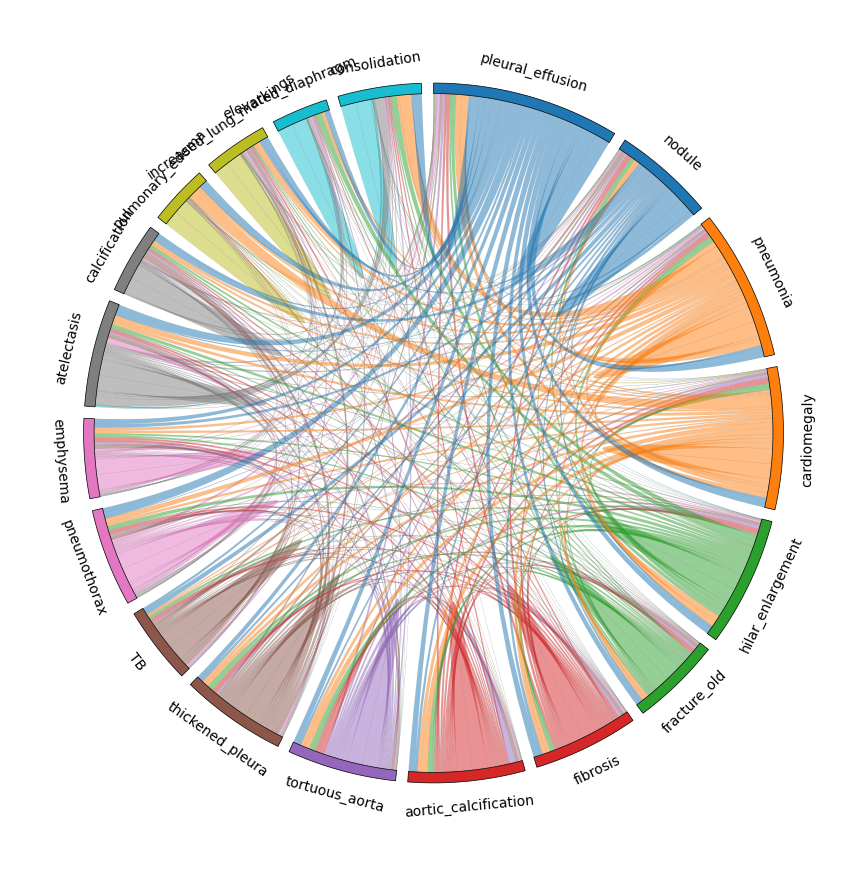

In [167]:
plot_cooccurence_matrix_circular(labels)

## Size Distribution

In [117]:
# compute mean and std of image sizes with tqdm progress bar
def compute_mean_std_image_size(image_dir: os.PathLike):
    """Computes the mean and std of the image sizes."""
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    
    sizes = []
    for image_file in tqdm(image_files):
        with Image.open(os.path.join(image_dir, image_file)) as img:
            sizes.append(img.size)
    
    sizes = np.array(sizes)
    return sizes.mean(axis=0), sizes.std(axis=0)

In [122]:
size_mean, size_std = compute_mean_std_image_size(image_path)

100%|██████████| 2140/2140 [00:00<00:00, 13255.12it/s]


In [124]:
print(f"Mean: {size_mean}, Std: {size_std}")

Mean: [1024. 1024.], Std: [0. 0.]


In [121]:
# compute mean and std of pixel intensity with tqdm progress bar
def compute_mean_std_pixel_intensity(image_dir: os.PathLike):
    """Computes the mean and std of the pixel intensity."""
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    
    pixel_intensities = []
    for image_file in tqdm(image_files):
        with Image.open(os.path.join(image_dir, image_file)) as img:
            pixel_intensities.append(np.array(img).mean())
    
    pixel_intensities = np.array(pixel_intensities)
    return pixel_intensities.mean(), pixel_intensities.std()

In [125]:
pixel_mean, pixel_std = compute_mean_std_pixel_intensity(image_path)

100%|██████████| 2140/2140 [00:37<00:00, 56.36it/s]


In [126]:
print(f"Mean: {pixel_mean}, Std: {pixel_std}")

Mean: 127.06274727170712, Std: 18.104919963540734


## Image Intensity Distributions

In [134]:
# compute mean and std of pixel intensity based on label with tqdm progress bar
def compute_mean_std_pixel_intensity_per_label(labels: pd.DataFrame, image_dir: os.PathLike):
    """Computes the mean and std of the pixel intensity based on the label."""
    all_labels = labels.columns[1:]
    
    pixel_intensities_per_label = {}
    for label in all_labels:
        image_files = labels[labels[label] == 1]['img_id'].tolist()
        
        pixel_intensities = []
        for image_file in tqdm(image_files):
            with Image.open(os.path.join(image_dir, image_file)) as img:
                pixel_intensities.append(np.array(img).mean())
        
        pixel_intensities = np.array(pixel_intensities)
        pixel_intensities_per_label[label] = (pixel_intensities.mean(), pixel_intensities.std())
    
    return pixel_intensities_per_label

In [135]:
pixel_mean_std_per_label = compute_mean_std_pixel_intensity_per_label(labels, image_path)

100%|██████████| 22/22 [00:00<00:00, 63.97it/s]


In [136]:
pixel_mean_std_per_label    

{'pleural_effusion': (129.77725646715737, 17.184542004723692),
 'nodule': (127.26465089437438, 16.720781620634636),
 'pneumonia': (128.6988232105075, 17.648006363631296),
 'cardiomegaly': (126.26268532664277, 19.735282254224913),
 'hilar_enlargement': (129.9768158446911, 16.851056073216157),
 'fracture_old': (131.9594916540479, 17.200688098684278),
 'fibrosis': (130.5813115252646, 14.139889714982518),
 'aortic_calcification': (127.46094034374624, 18.600641249799548),
 'tortuous_aorta': (128.567747782994, 18.867671584088082),
 'thickened_pleura': (129.87192589997358, 16.327315816941503),
 'TB': (127.26740952710199, 14.80838783167348),
 'pneumothorax': (129.10184232866442, 16.07078398578609),
 'emphysema': (119.40197722117107, 20.074535337721397),
 'atelectasis': (129.49583246427423, 15.400963120564416),
 'calcification': (127.76466162388141, 17.07860820717901),
 'pulmonary_edema': (108.1513772377601, 20.18382205053719),
 'increased_lung_markings': (125.29841060638428, 16.761929666098112

In [142]:
# plot bar chart of pixel mean and std intensities per label
def plot_pixel_intensity_bar_chart(pixel_mean_std_per_label: dict):
    """Plots the bar chart of the pixel mean and std intensities per label."""
    labels = list(pixel_mean_std_per_label.keys())
    pixel_mean = [pixel_mean_std_per_label[label][0] for label in labels]
    pixel_std = [pixel_mean_std_per_label[label][1] for label in labels]
    
    plt.figure(figsize=(20, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)
    
    plt.bar(labels, pixel_mean, yerr=pixel_std)
    plt.xticks(rotation=90)
    
    plt.show()

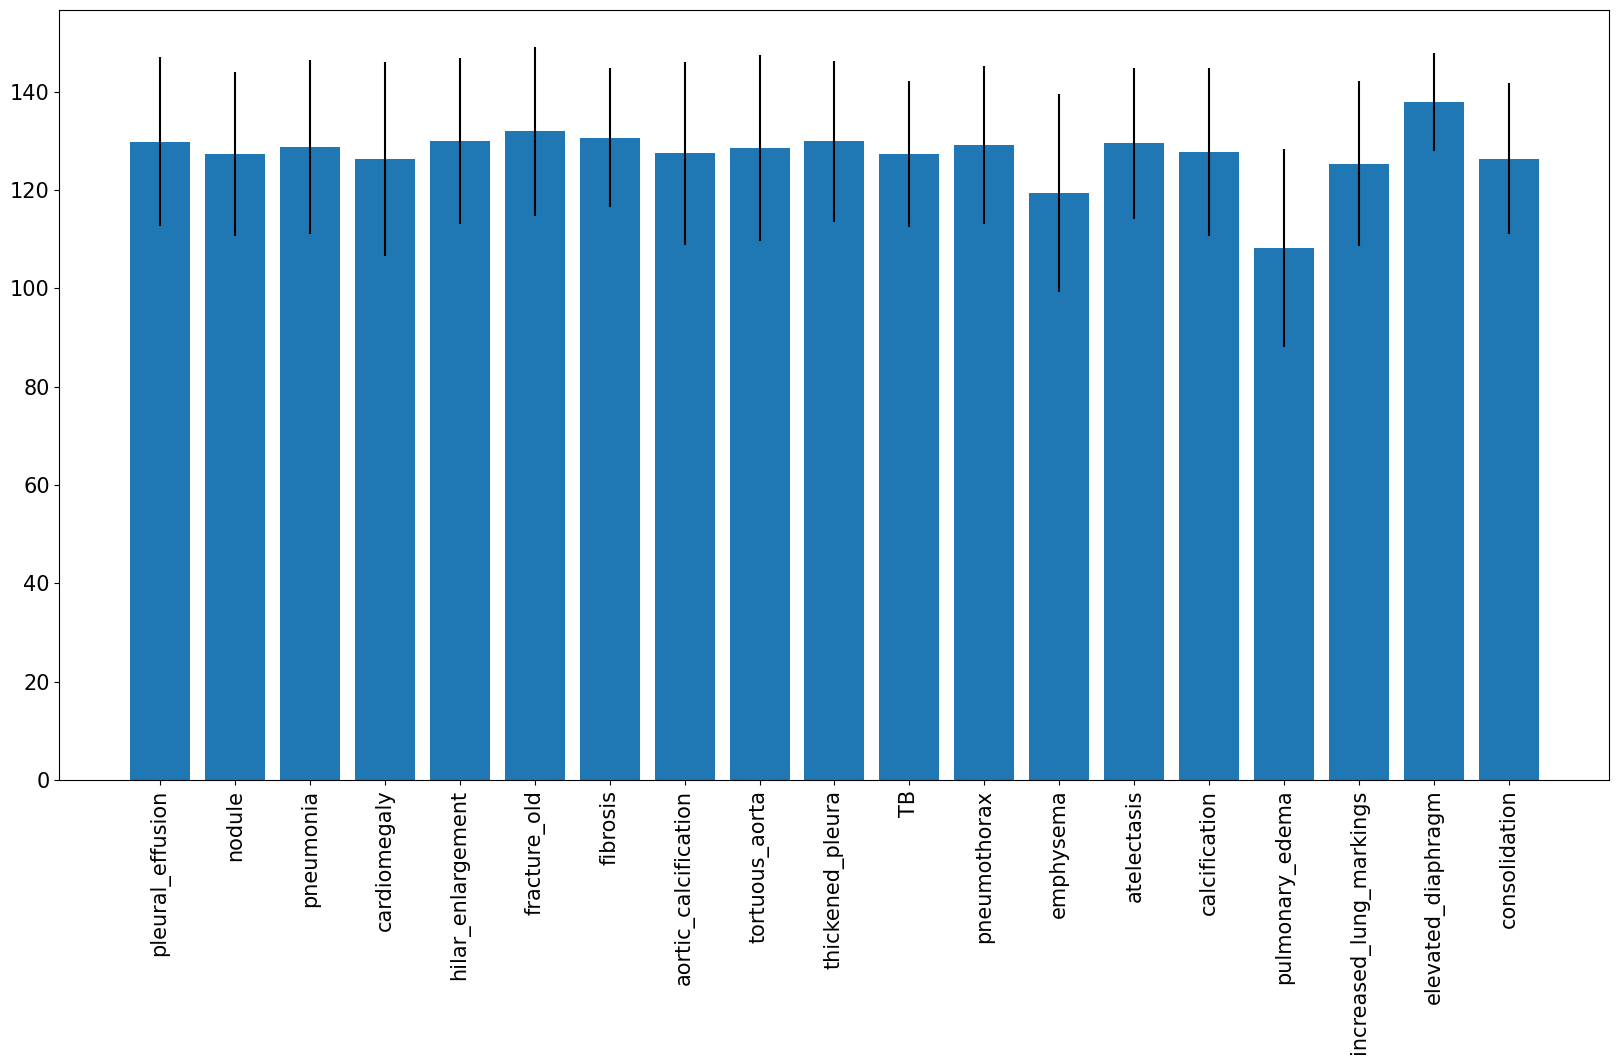

In [143]:
plot_pixel_intensity_bar_chart(pixel_mean_std_per_label)

In [131]:
# plot histogram of pixel intensity based on label in one plot with tqdm progress bar
def plot_pixel_intensity_histogram(labels: pd.DataFrame, image_dir: os.PathLike):
    """Plots the pixel intensity histogram based on the label."""
    all_labels = labels.columns[1:]
    
    plt.figure(figsize=(20, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)
    
    for label in all_labels:
        image_files = labels[labels[label] == 1]['img_id'].tolist()
        
        pixel_intensities = []
        for image_file in tqdm(image_files):
            with Image.open(os.path.join(image_dir, image_file)) as img:
                pixel_intensities.append(np.array(img).mean())
        
        pixel_intensities = np.array(pixel_intensities)
        plt.hist(pixel_intensities, bins=100, alpha=0.5, label=label)
    
    plt.legend(loc='upper right')
    plt.show()

100%|██████████| 22/22 [00:00<00:00, 60.55it/s]


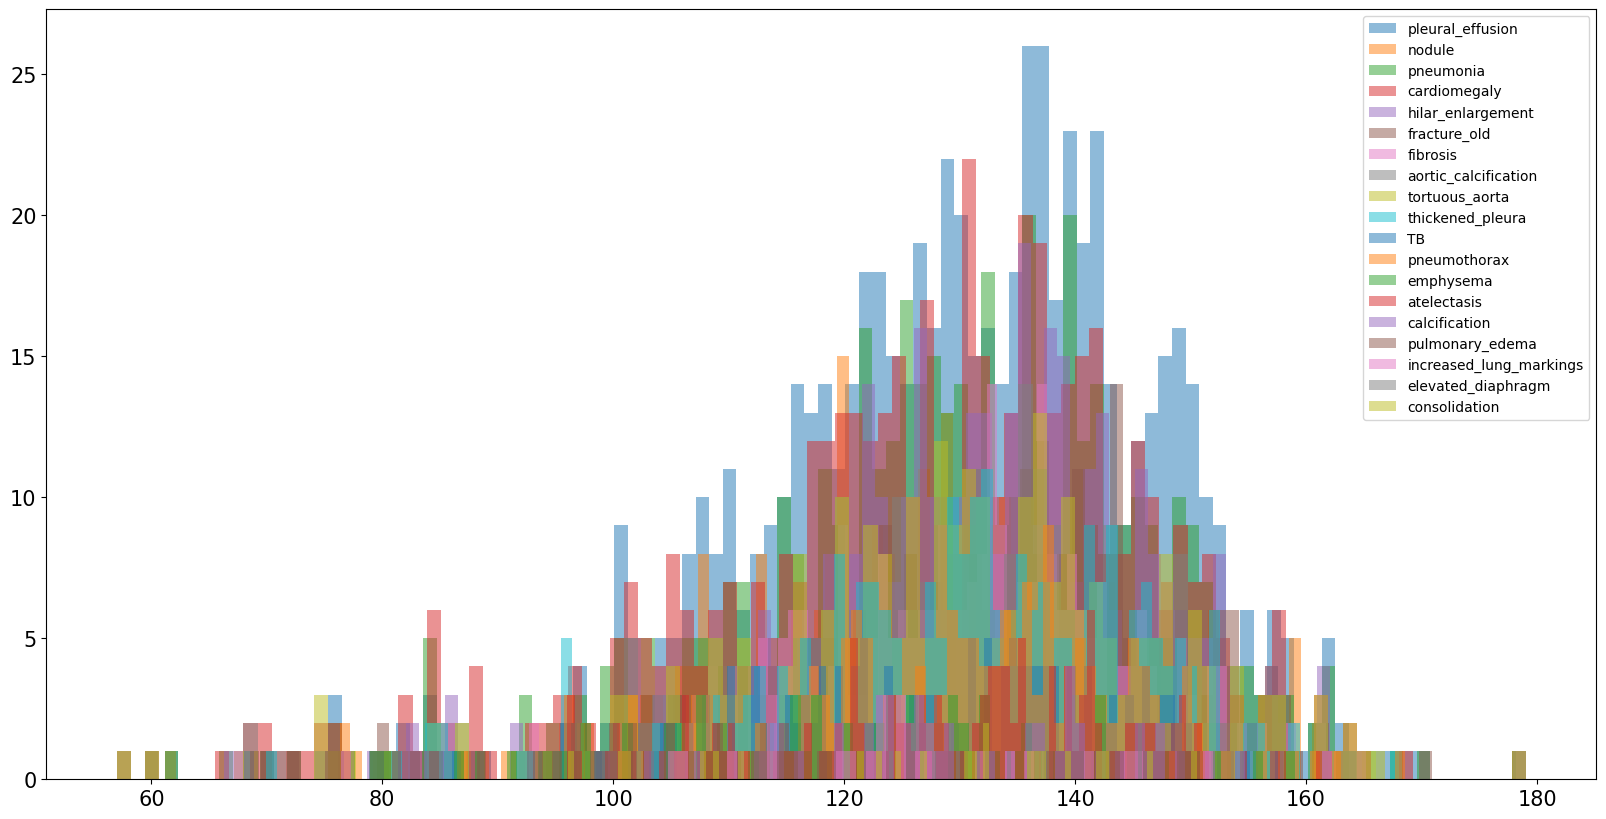

In [132]:
plot_pixel_intensity_histogram(labels, image_path)